https://mp.weixin.qq.com/s/CtFvURdJR314OBFDhu5hGg

In [1]:
# 导入所需的库
import torch
from torch import nn
from torch import optim
from torchvision.transforms import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

torch.Size([3, 32, 32])


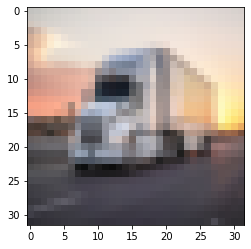

In [6]:
transform = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor()
    ]
)
flat_img = 3072
img = Image.open('../dataset/truck.jpg')
real_img = transform(img)
torch.manual_seed(2)
fake_img = torch.rand(1,100)
# print(real_img.size())
plt.imshow(np.transpose(real_img.numpy(),(1,2,0)))
# plt.imshow(real_img.numpy())
print(real_img.size())

In [7]:
# 创建一个判别器模型
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(flat_img,10000),
            nn.ReLU(),
            nn.Linear(10000,1),
            nn.Sigmoid()
        )
    def forward(self,img):
        img = img.view(1,-1)
        out = self.linear(img)
        return out

In [8]:
# 创建一个生成器模型
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(100,10000),
            nn.LeakyReLU(),
            nn.Linear(10000,4000),
            nn.LeakyReLU(),
            nn.Linear(4000,flat_img)
        )
    def forward(self,latent_space):
        latent_space = latent_space.view(1,-1)
        out = self.linear(latent_space)
        return out

In [10]:
# 初始化模型，优化器和损失函数
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
discr = Discriminator().to(device)
gen = Generator().to(device)
opt_d = optim.SGD(discr.parameters(),lr=0.001,momentum=0.9)
opt_g = optim.SGD(gen.parameters(),lr=0.001,momentum=0.9)
criterion = nn.BCELoss()

In [ ]:
epochs = 500
discr_e = 4
gen_e = 3
for epoch in tqdm(range(epochs),total=epochs):
    for k in range(discr_e):
        opt_d.zero_grad()
        out_d1 = discr(real_img.to(device))
        # loss for real image
        loss_d1 = criterion(out_d1,torch.ones((1,1)).to(device))
        loss_d1.backward()
        out_d2 = gen(fake_img.to(device)).detach()
        # loss for fake image
        loss_d2 = criterion(discr(out_d2.to(device)),torch.zeros((1,1)).to(device))
        loss_d2.backward()
        opt_d.step()
    # generator training
    for i in range(gen_e):
        opt_g.zero_grad()
        out_g = gen(fake_img.to(device))
        loss_g = torch.log(1.0-(discr(out_g.to(device))))
        loss_g.backward()
        opt_g.step()